## Text Analytics

1. Text Retrieval <br>
[Text Retrieval](#text_retrieval)
2. Text Analysis <br>
[Review Statistics](#statistics) <br>
[Part of Speech (POS) Tagging](#pos_tagging) <br>
[N-gram language generation](#n_gram) <br>


3. Text Analytics <br>
Topic Analysis <br>
[Latent Semantic Analysis (LSA)](#lsa) <br>
[Latent Dirichlet Allocation (LDA)](#lda)<br>
 Learning Topic Class <br>
[Neural Network](#bert) <br>



<a id='header'></a>
Header

<a id='text_retrieval'></a>
#### 1. Text Retrieval
In this section, over 1.9k iOS store reviews of nine different competitive mobile games are retrieved for analysis. The games are of different types, but they share one common characteristic: they are competitive. Players compete with other players for winning. Therefore, although they have different gaming types, they share an important features in common: human interaction, especially competition. Mobile games gain increasing importances in the gaming market. With most games being competitive, this analysis aims to dig into the gaming industry and see what do players think of the games they play. The following is the table for it. 

| Game_name | Game_id | Source | Type |
| --- | --- | --- | --- |
| Clash of Clans | 529479190 | iOS Store | Strategy |
| Clash Royale | 1053012308 | iOS Store | Strategy | 
| Mobile Legend: Bang Bang | 1160056295 | iOS Store | MOBA |
| Arena of Valor | 1150318642 | iOS Store | MOBA |
| Modern Combat 5 | 656176278 | iOS Store | FPS Shooting |
| Bullet Force | 1009134067 | iOS Store | FPS | 
| PUBG Mobile | 1330123889 | iOS Store | Strategy/Action |
| FIFA Soccer | 1094930513 | iOS Store | eSports | 
| NBA Live Mobile Basketball | 1055502792 | iOS Store | eSports|

In [1]:
# section importing the data
from bs4 import BeautifulSoup
from urllib.request import urlopen
import time
import re
import requests
from requests.exceptions import HTTPError
import urllib
import csv
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

In [2]:
def isEnglish(s): # remove non-english reviews
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:    
        return True
def convert_to_lowercase(inputstr):
    return inputstr.lower()
def removePunctuation(inputstr):
    return re.sub(r'[^\w\s]', '', inputstr)
def removeStopwords(inputstr, sw):
    word_tokens = nltk.word_tokenize(inputstr)
    filtered = [word for word in word_tokens if word not in sw]
    s = " "
    return s.join(filtered)
def lemmatize(inputstr, lemmatizer):
    word_tokens = nltk.word_tokenize(inputstr)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_tokens]
    return " ".join(lemmatized)
def cleanstr(inputstr, sw, lemmatizer):
    return lemmatize(removeStopwords(removePunctuation(convert_to_lowercase(inputstr)), sw), lemmatizer)

In [3]:
app_ids = ["529479190", "1053012308", "1160056295", "1150318642", "656176278", "1009134067", 
           "1330123889", "1094930513", "1055502792"] # target apps in iOS store
review = dict() # resulting dictionary
lemmatizer = WordNetLemmatizer() 
sw = stopwords.words('english')
for app_id in app_ids: 
    for page in range(1, 21): # get the first 20 pages of review for each game
        url = "https://itunes.apple.com/us/rss/customerreviews/page=" + str(page) \
              + "/id=" + app_id + "/sortby=mostrecent/xml?urlDesc=/customerreviews/id=" + app_id + "/xml"
        response= requests.get(url)
        soup = BeautifulSoup(response.content,"html.parser")
        matches = soup.findAll("entry") # find the matching items
        # obtain a list of items: app_id, review title, review time, review rating and review content for each review
        for m in matches: 
            review_title = m.find("title").text # obtain the review title
            review_content = m.find("content").text # obtain the review content
            # collect only the English reviews
            if isEnglish(review_title) == True and isEnglish(review_content) == True:
                review_time = m.find("updated").text[:10] # obtain the review time
                review_rating = m.find("im:rating").text # obtain the review rating
                # put the list of items into dictionary, identified by key (review_id)
                review[m.find("id").text] = [app_id, cleanstr(review_title, sw, lemmatizer), review_time, 
                                             review_rating, cleanstr(review_content, sw, lemmatizer)]      

<a id='statistics'></a>
#### 2. Text Analysis
#### 2.1 Review Statistics

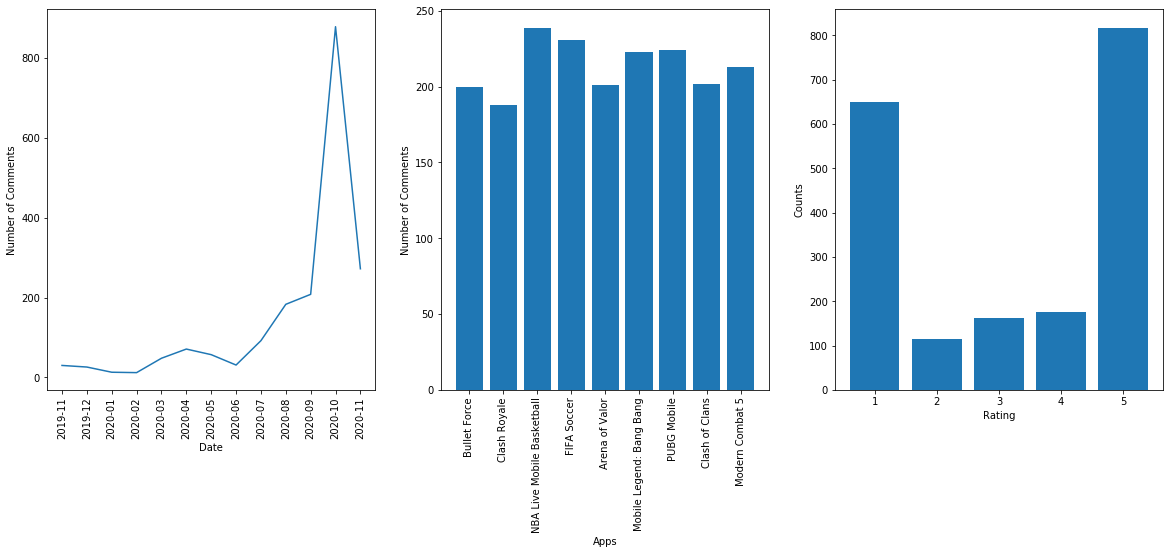

In [19]:
import matplotlib.pyplot as plt
from datetime import datetime as dt

df_reviews = pd.DataFrame.from_dict(review, orient = 'index')
df_reviews.columns = ['app_id', 'title', 'time', 'rating', 'content']
df_reviews['time_month'] = pd.to_datetime(df_reviews['time'], format = '%Y-%m-%d').dt.strftime("%Y-%m")
dates_df = df_reviews[['time_month','rating']].groupby(by = 'time_month').count()
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.plot(dates_df.index, dates_df['rating'])
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation = 90)
apps_df = df_reviews[['rating', 'app_id']].groupby(by = 'app_id').count()
app_dict = {
    529479190: 'Clash of Clans', 1053012308: 'Clash Royale', 1160056295: 'Mobile Legend: Bang Bang', 
    1150318642: 'Arena of Valor', 656176278: 'Modern Combat 5', 1009134067: 'Bullet Force', 
    1330123889: 'PUBG Mobile', 1094930513: 'FIFA Soccer', 1055502792: 'NBA Live Mobile Basketball'
}
apps_df['app_names'] = [val for ind in apps_df.index for key, val in app_dict.items() if int(ind )== key]
for key, val in app_dict.items():
    apps_df.loc[key, 'app_names'] = val
plt.subplot(1,3,2)
plt.bar(apps_df['app_names'], apps_df['rating'])
plt.xlabel('Apps')
plt.ylabel('Number of Comments')
plt.xticks(rotation = 90)
plt.subplot(1,3,3)
ratings_df = df_reviews[['rating', 'app_id']].groupby(by = 'rating').count()
plt.bar(ratings_df.index, ratings_df['app_id'])
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

More reviews are available for dates closer to the date when the data is collected. It makes sense because only the first 20 pages of reviews are scrapped and loaded. A relatively small number of reviews at earlier dates. I would expect that the activity level (number of reviews) would stay the same over time. An gradually increasing number of review is probably due to the way Apple list reviews. The reviews are probably organized by time window but not exact dates (this is a guess). <br>
The number of reviews from each game mentioned are the similar. Most reviews are leaning towards extremum (1 or 5). This phenomena can be explained by people's motive to leave comments. People feeling ok about the game are less likely to leave comments, whereas peoeple who have strong feelings on the game are more likely to leave comments. 

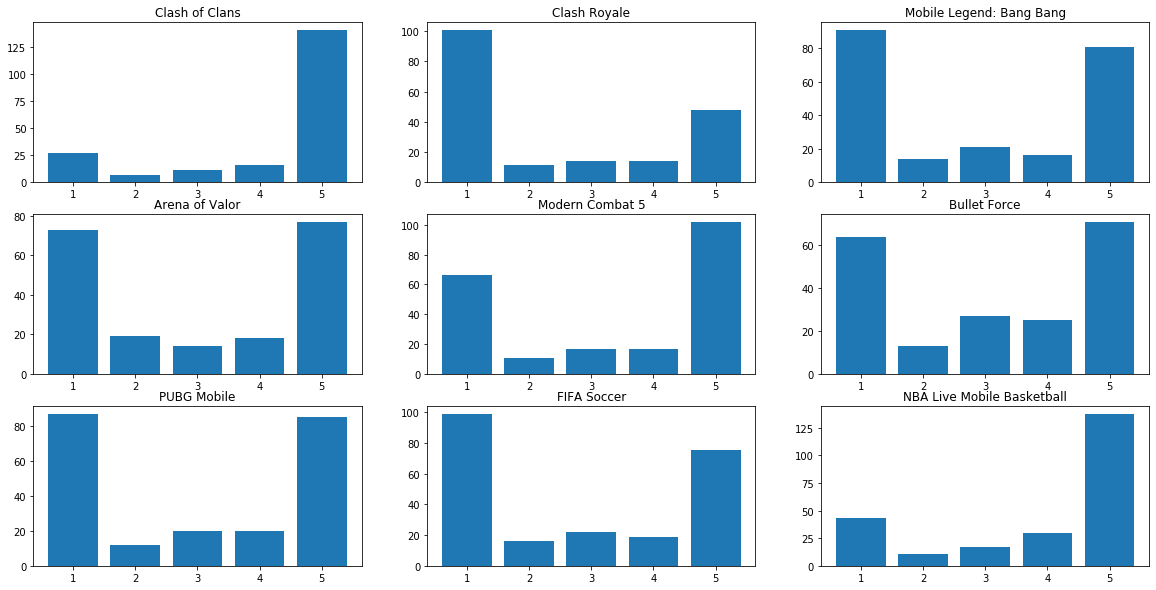

In [8]:
plt.figure(figsize=(20,10))
app_time_df = df_reviews[['time_month','rating', 'app_id']]
ax1 = plt.subplot2grid((3,3), (0,0))
app_time = app_time_df[app_time_df['app_id'] == app_ids[0]].groupby(by = 'rating').count()
ax1.bar(app_time.index, app_time['time_month'])
ax1.title.set_text(app_dict[int(app_ids[0])])
ax2 = plt.subplot2grid((3,3), (0,1))
app_time = app_time_df[app_time_df['app_id'] == app_ids[1]].groupby(by = 'rating').count()
ax2.bar(app_time.index, app_time['time_month'])
ax2.title.set_text(app_dict[int(app_ids[1])])
ax3 = plt.subplot2grid((3,3), (0,2))
app_time = app_time_df[app_time_df['app_id'] == app_ids[2]].groupby(by = 'rating').count()
ax3.bar(app_time.index, app_time['time_month'])
ax3.title.set_text(app_dict[int(app_ids[2])])
ax4 = plt.subplot2grid((3,3), (1,0))
app_time = app_time_df[app_time_df['app_id'] == app_ids[3]].groupby(by = 'rating').count()
ax4.bar(app_time.index, app_time['time_month'])
ax4.title.set_text(app_dict[int(app_ids[3])])
ax5 = plt.subplot2grid((3,3), (1,1))
app_time = app_time_df[app_time_df['app_id'] == app_ids[4]].groupby(by = 'rating').count()
ax5.bar(app_time.index, app_time['time_month'])
ax5.title.set_text(app_dict[int(app_ids[4])])
ax6 = plt.subplot2grid((3,3), (1,2))
app_time = app_time_df[app_time_df['app_id'] == app_ids[5]].groupby(by = 'rating').count()
ax6.bar(app_time.index, app_time['time_month'])
ax6.title.set_text(app_dict[int(app_ids[5])])
ax7 = plt.subplot2grid((3,3), (2,0))
app_time = app_time_df[app_time_df['app_id'] == app_ids[6]].groupby(by = 'rating').count()
ax7.bar(app_time.index, app_time['time_month'])
ax7.title.set_text(app_dict[int(app_ids[6])])
ax8 = plt.subplot2grid((3,3), (2,1))
app_time = app_time_df[app_time_df['app_id'] == app_ids[7]].groupby(by = 'rating').count()
ax8.bar(app_time.index, app_time['time_month'])
ax8.title.set_text(app_dict[int(app_ids[7])])
ax9 = plt.subplot2grid((3,3), (2,2))
app_time = app_time_df[app_time_df['app_id'] == app_ids[8]].groupby(by = 'rating').count()
ax9.bar(app_time.index, app_time['time_month'])
ax9.title.set_text(app_dict[int(app_ids[8])])

Except Clash of Clans, all games share similar rating patterns: high occurrences of both extremum (rating 1 or 5). Similar to the rating distribution of all games, only gamers who have extreme feelings about the game would likely leave comments. Clash of Clan, however, enjoys a high positive rating without too many negative comments. It is worth studying why is it the case for clash of clans.  

<a id='pos_tagging'></a>
#### 2.2 Part of Speech (POS) Tagging
In this section, the reviews are all combined into one. The words from different reviews are tagged with word-category (noun, verb, adjective, adverb, etc.). Then a brief analysis is done on the POS tagging. 

In [9]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
# nltk.download('brown')
# nltk.download('averaged_perceptron_tagger')

In [10]:
def get_target_word(word_tokens): 
    """ 
    This function converts past tense/past principle to simple present tense
    input: tokenized words
    output: stemmed words
    """ 
    p_stemmer = PorterStemmer()
    w_lemma = WordNetLemmatizer()
    p_stemmed = [p_stemmer.stem(word) for word in word_tokens]
    tags = nltk.pos_tag(p_stemmed)
    tot_words = len(tags)
    for i in range(tot_words):
        if tags[i][1].startswith('V'):
            p_stemmed[i] = w_lemma.lemmatize(p_stemmed[i], 'v')
    return p_stemmed
def tagging_speech(document_list): # part of speech tagging
    document = " ".join(document_list) # join the reviews into one
    tokenizer = RegexpTokenizer(r'\w+') # define tokenizer
    tokens = tokenizer.tokenize(document) # token
    stemmed_tokens = get_target_word(tokens) # stemming and process verbs
    tags = nltk.pos_tag(stemmed_tokens)
    return tags

In [11]:
tags = tagging_speech(df_reviews['content'])
print('total words in all review contents:', len(tags))
tag_fd = nltk.FreqDist(tag for (word, tag) in tags)
print(tag_fd.most_common())

total words in all review contents: 23517
[('NN', 11793), ('JJ', 4446), ('VBP', 1615), ('RB', 1237), ('VB', 1166), ('CD', 828), ('IN', 515), ('NNS', 490), ('VBD', 272), ('MD', 221), ('JJS', 144), ('JJR', 122), ('VBZ', 120), ('VBN', 91), ('FW', 85), ('RBR', 79), ('DT', 70), ('NNP', 38), ('RP', 31), ('VBG', 25), ('CC', 25), ('RBS', 20), ('WP', 20), ('$', 14), ('WDT', 13), ('TO', 11), ('PRP', 10), ('PRP$', 6), ('WRB', 5), ('EX', 3), ('WP$', 1), ('``', 1)]


Observe that the number of total words in all reviews (1963 reviews) is 24280. Through an attempt to assign word categories to the words, a primary result of the POS tagging can be shown below. Given the total number of reviews, the word of review contents can each be tagged with word categories. The following table presents only some tags. 

| Tag | Meaning | 
| --- | --- |  
| NN | noun | 
| JJ | adjective | 
| VBP | verb (present, non-singular) | 
| RB | adverb | 
| VB | verb |
| CD | cardinal digit | 
| IN | preposition/subordinating conjunction | 


----------
1. Since the many stopwords have been removed from the review content, so most words in the reviews are the "essential" words, mostly noun, verb, adjective and adverbs. 
2. The pie chart illustrated below shows the percentage by word category in the cleaned (and with stopword removed) review content. In the verb category, verb of different tenses are also included. 
3. Verbs in past tense and past principles also exists (although in relatively small number) in POS tagging even after applying WordNetLemmatizer() for verb. By examining some of the vbd (verb with past tense), I discover that thare are mixed reasons for their existence. For example, the word "stroke" itself can be a verb (stroke - stroked - stroked), or a past tense of strike.

----------


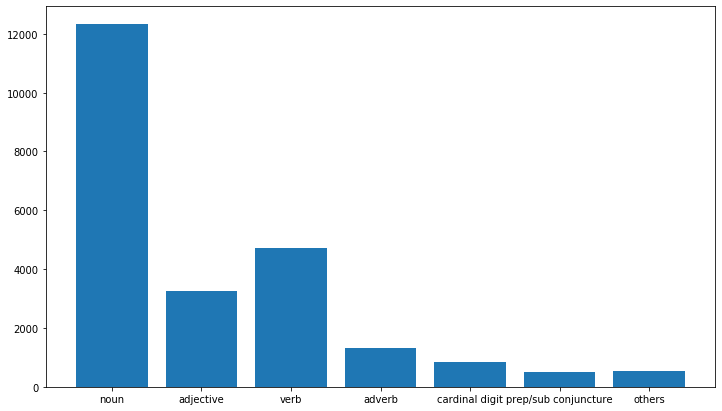

In [12]:
noun_type = ['NN', 'NNS', 'NNP']
verb_type = ['VBP', 'VB', 'VBD', 'VBZ', 'VBN']
adj_type = ['JJ', 'JJS', 'JJR']
adv_type = ['RB', 'RBS', 'RBR']
digit = ['CD']
conj = ['IN']
tag_num = []
cc = [noun_type, verb_type, adj_type, adv_type, digit, conj]
for c in cc:
    countt = 0
    for (tag, count) in tag_fd.most_common():
        if tag in c: 
            countt+= count
    tag_num.append(countt)
tag_num.append(len(tags) - sum(tag_num))
import matplotlib.pyplot as plt
tag_names = ['noun', 'adjective', 'verb', 'adverb', 'cardinal digit', 'prep/sub conjuncture', 'others']
plt.figure(figsize = (12,7))
plt.bar(tag_names, tag_num)
plt.show()

Investigate the top occurred words by category. 

In [13]:
noun_type = ['NN', 'NNS', 'NNP']
verb_type = ['VBP', 'VB', 'VBD', 'VBZ', 'VBN']
adj_type = ['JJ', 'JJS', 'JJR']
adv_type = ['RB', 'RBS', 'RBR']
def count_word_cat(word_tag, category):
    word_list = [word for (word, tag) in word_tag if tag in category]
    count_dict = dict()
    for word in set(word_list):
        count_dict[word] = word_list.count(word)
    return count_dict

In [14]:
# top 10 by each category
# did not write a function b/c function runs very slow
noun_df = pd.DataFrame.from_dict(count_word_cat(tags, noun_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
noun_df.reset_index(inplace = True)
noun_df.columns = ['noun', 'noun_count']
verb_df = pd.DataFrame.from_dict(count_word_cat(tags, verb_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
verb_df.reset_index(inplace = True)
verb_df.columns = ['verb', 'verb_count']
adj_df = pd.DataFrame.from_dict(count_word_cat(tags, adj_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
adj_df.reset_index(inplace = True)
adj_df.columns = ['adj', 'adj_count']
adv_df = pd.DataFrame.from_dict(count_word_cat(tags, adv_type), orient = 'index', columns = ['count']).sort_values(by = ['count'], ascending=False, inplace=False)
adv_df.reset_index(inplace = True)
adv_df.columns = ['adv', 'adv_count']

In [15]:
top_10 = pd.concat([noun_df.iloc[:10,:], verb_df.iloc[:10,:], adj_df.iloc[:10,:], adv_df.iloc[:10,:]], axis = 1)
top_10

,noun,noun_count,verb,verb_count,adj,adj_count,adv,adv_count
0,game,1554,get,292,good,238,even,103
1,play,340,make,255,updat,145,back,96
2,player,219,play,123,great,139,also,79
3,time,191,go,118,new,128,ever,69
4,pleas,140,say,91,best,76,still,68
5,team,127,want,88,u,74,better,57
6,fun,122,take,86,much,70,alway,50
7,money,108,love,81,bad,61,never,49
8,get,99,need,75,lose,48,server,41
9,match,96,keep,69,graphic,48,well,29


Through the POS tagging task, it is natural to realize that noun is the most frequently occurred word category amongst all reviews. By reviewing some top nouns, we may see what do players of competitive games concern the most. Aside from the top word game, the second top word is script, which could probably refer to the game script itself or players' script manipulation. <br>
Some adjective also helps to understand how does the people view the game. <br>

<a id='n_gram'></a>
#### 2.3 N-gram language generation
Then we could use n-gram by frequency to get to know what are most players saying out of their words. Since nouns are consists of most of the review word category, the following analysis will focus on nouns. 

In [20]:
def get_bglist(document_list):
    bglist = list()
    for document in document_list:
        document = document.split(" ")
        for i in range(len(document)-1):
            bglist.append((document[i], document[i+1]))
    bigram = dict((x,bglist.count(x)) for x in sorted(set(bglist), key=bglist.index))
    return bigram
def createsentence(seedword, len_sent = 5):
    # sort the dictionary by bigram occurrences
    sorteddict = {k: v for k, v in sorted(bigram.items(), key=lambda item: item[1], reverse = True)}
    def next_word(wordsss): 
        # obtain all bigrams containing the target word in the first position
        # get the bigram with the highest frequency, and select the next word
        next_word = [word for word in sorteddict.keys() if wordsss in word[0]][0][1]
        return next_word
    final_str = seedword
    for i in range(len_sent):
        final_str = " ".join([final_str, next_word(seedword)])
        seedword = next_word(seedword)
    return final_str

In [21]:
bigram = get_bglist(df_reviews['content'])

In [22]:
for word in noun_df.iloc[:10,0]:
    print(createsentence(word, 5))

game ever time try get back
play game ever time try get
player like game ever time try
time try get back game ever
pleas fix game ever time try
team play game ever time try
fun game ever time try get
money game ever time try get
get back game ever time try
match making game ever time try


Review the generated language based on the top 10 hitted nouns. Many sentence would end up with word like "game", "try", and "get". This is probably because "game" is the top hitted word among the nouns. So the generated sentence would very likely end up on "game". A way to improve this is to try trigram instead. 

In [23]:
def get_tglist(document_list):
    tglist = list()
    for document in document_list:
        document = document.split(" ")
        for i in range(len(document)-2):
            tglist.append((document[i], document[i+1], document[i+2]))
    trigram = dict((x,tglist.count(x)) for x in sorted(set(tglist), key=tglist.index))
    return trigram
def createsentence_trigram(seedword, len_sent = 6):
    # sort the dictionary by bigram occurrences
    sorteddict = {k: v for k, v in sorted(trigram.items(), key=lambda item: item[1], reverse = True)}
    def next_words(wordsss): 
        # obtain all bigrams containing the target word in the first position
        # get the bigram with the highest frequency, and select the next word
        next_word1 = [word for word in sorteddict.keys() if wordsss in word[0]][0][1]
        next_word2 = [word for word in sorteddict.keys() if wordsss in word[0]][0][2]
        return next_word1, next_word2
    final_str = seedword
    for i in range(round(len_sent/2)):
        word1, word2 = next_words(seedword)
        final_str = " ".join([final_str, word1, word2])
        seedword = word2
    return final_str

In [24]:
trigram = get_tglist(df_reviews['content'])

In [25]:
for word in noun_df.iloc[:10,0]:
    print(createsentence_trigram(word, 6))

game ever played many account started knee
play bot match making game ever played
player bot match making game ever played
time try play bot match making game
pleas make game ever played many account
team need developed old version open play
fun game play bot match making game
money make game ever played many account
get new phone 11 pro search hard
match making game ever played many account


In [34]:
for word in verb_df.iloc[:10,0]:
    print(createsentence_trigram(word, 6))

get new phone 11 pro search hard
make game better anti cheat pay win
play bot match making game ever played
go game really good game ever played
say server overloaded please fix good game
want new event builder base unlimited loot
take long time try play bot match
love game much money need regional server
need regional server need regional server need
keep good work hard get new phone


#### 3. N-gram language generation (TF-IDF Matrix)

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer
doc = list(df_reviews['content'])
tfidf_vectorizer = TfidfVectorizer(use_idf = False) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(doc)
df = pd.DataFrame(tfidf_vectorizer_vectors.T.todense(), index = tfidf_vectorizer.get_feature_names(), columns = df_reviews.index)

In [242]:
most_relavant_val = df.idxmax()
most_relavant_val[:10]

6574356968    amazing
6573998856    5000000
6573400182      level
6573394674       clan
6573169297        yes
6572967526        fun
6570957159       clan
6570344378      yummy
6570199356       clan
6570144465       good
dtype: object

The above list shows the most relevant word in each of the 10 documents (identified by review id). 

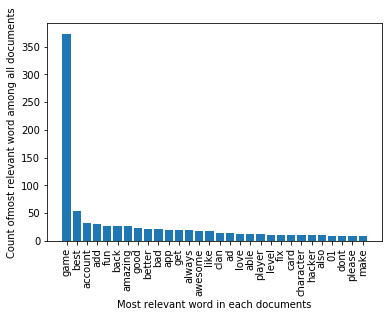

In [254]:
relevant_list = [(word,  list(most_relavant_val).count(word)) for word in set(list(most_relavant_val))] 
df_relevant = pd.DataFrame()
df_relevant['r_word'] = [item[0] for item in relevant_list]
df_relevant['count'] = [item[1] for item in relevant_list]
df_relevant.sort_values(by = 'count', inplace = True, ascending = False)
plt.bar(df_relevant['r_word'][:30], df_relevant['count'][:30])
plt.xlabel('Most relevant word in each documents')
plt.ylabel('Count ofmost relevant word among all documents')
plt.xticks(rotation = 90)
plt.show()

The plot above tells about the most relevant word (marked by high term frequency in single document but low document frequency in whole document collection). Among over 1,900 reviews, the most relevant word of over 350 of them is game. Then the count quickly drops as high dfidf accounts for low document frequency as well. Still, the most relevant words could be provide insights on how players view the games. 

In [259]:
print(sum(df_relevant['count'][:30])/len(df_reviews.index))
for word in df_relevant['r_word'][:15]:
    print(createsentence_trigram(word, 5))

0.45728900255754473
game ever played game year
best game ever time try
account back got updating content
add global chat much fun
fun competitive game ever played
back global chat much fun
amazing game playing long time
good game really good game
better anti cheat customer service
bad need global chat back
app cant get old account
get old account back got
always tell clan war 2
awesome playing like game lot
like game lot money game


The first 15 of the most relevant word accounts for the most relevant word for around 46% of the reviews (documents). Then we may discuss how the most relevant word can be used to generate the word sequence. 7 out of 15 (over half) of the generated language is associated with good sentimen. 3 out of 15 is about account issues (old account and update). 3 out of 15 is about global chat (need it or add it back). 1 is about anti-cheating issues. The generated langauges suggests three issues that the players concern the most, two of which could be equally important. Game developers should look into these features: accout/update issues, global chat function and anti-cheating customer service. 

#### 3.1 Topic Modelling
<a id='lsa'></a>
#### 3.1.1 Latent Semantic Analysis (LSA)

In [54]:
# tokenize 
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def preprocess_data(documents_list):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = PorterStemmer()
    txt = []
    for raw in documents_list:
        tokens = tokenizer.tokenize(raw)
        words = [word for word in tokens]
        stemmed_tokens = [stemmer.stem(word) for word in words]
        txt.append(stemmed_tokens)
    return txt
def prepare_corpus(cleaned_documents_list):
    dictionary = corpora.Dictionary(cleaned_documents_list)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_documents_list]
    return dictionary, doc_term_matrix
def create_gensim_lsa_model(clean_documents_list,number_of_topics,words):
    dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary) 
    return lsamodel
def compute_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step):
    coherence_values = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = term_dictionary) 
        coh_model = CoherenceModel(model=model, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v')
        coherence_values.append(coh_model.get_coherence())
    return coherence_values
def plot_graph(coherence_values,start, stop, step):
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

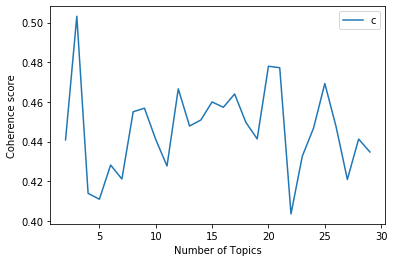

In [98]:
start,stop,step = 2, 30, 1
document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

In [112]:
import seaborn as sns
def average_num_topics(start, stop, step, iterations, document_list):
    num_topics = list()
    plt.figure(figsize = (12,7))
    for i in range(iterations):
        clean_documents_list = preprocess_data(document_list)
        term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
        coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list,start,stop,step)
        plt.subplot(((iterations-1)//3)+1,3,i+1)
        sns.barplot(list(range(start,stop,step)), coherence_values)
        num_topics.append(list(range(start,stop,step))[coherence_values.index(max(coherence_values))])
    return num_topics

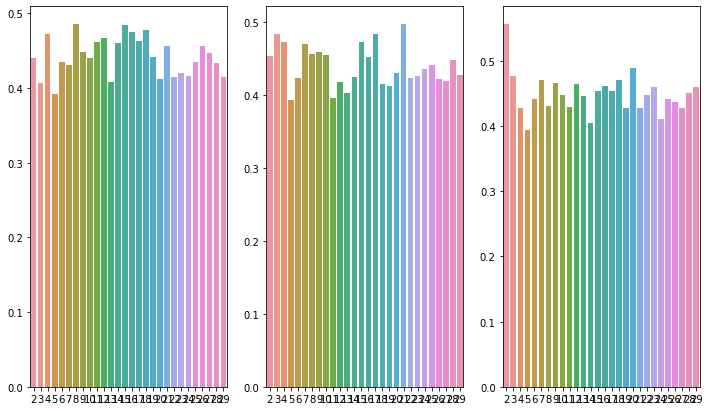

In [113]:
num_topics_list = average_num_topics(2, 30, 1, 3, df_reviews['content'])

In [116]:
# get the best coherence score for each iteration
num_topics_list

[8, 21, 2]

In [121]:
number_of_topics = 2 
words=10
model=create_gensim_lsa_model(clean_documents_list,number_of_topics,words)
for idx, topic in model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.826*"game" + 0.259*"play" + 0.170*"get" + 0.124*"like" + 0.114*"make" + 0.114*"player" + 0.090*"good" + 0.086*"time" + 0.080*"would" + 0.078*"love"
Topic: 1 Word: 0.592*"need" + 0.576*"server" + 0.559*"region" + -0.068*"game" + -0.009*"make" + -0.008*"play" + -0.007*"good" + -0.006*"money" + 0.005*"fix" + -0.004*"mobil"


In [122]:
number_of_topics = 21
words=10
model=create_gensim_lsa_model(clean_documents_list,number_of_topics,words)
for idx, topic in model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.826*"game" + 0.259*"play" + 0.170*"get" + 0.124*"like" + 0.114*"make" + 0.114*"player" + 0.090*"good" + 0.086*"time" + 0.080*"would" + 0.078*"love"
Topic: 1 Word: 0.592*"need" + 0.576*"server" + 0.559*"region" + -0.068*"game" + -0.009*"make" + -0.008*"play" + -0.007*"good" + -0.006*"money" + 0.005*"fix" + -0.004*"mobil"
Topic: 2 Word: -0.517*"get" + 0.466*"game" + -0.381*"play" + -0.194*"match" + -0.186*"would" + -0.179*"like" + -0.159*"player" + -0.152*"make" + -0.107*"team" + -0.098*"cant"
Topic: 3 Word: -0.492*"like" + -0.411*"make" + 0.406*"get" + -0.356*"player" + -0.169*"u" + 0.158*"play" + -0.126*"pleas" + 0.125*"game" + 0.110*"mom" + -0.104*"also"
Topic: 4 Word: -0.713*"play" + 0.432*"get" + 0.196*"pleas" + 0.182*"mom" + 0.140*"level" + 0.127*"make" + -0.120*"love" + 0.115*"card" + 0.100*"go" + 0.099*"back"
Topic: 5 Word: 0.585*"like" + -0.439*"player" + -0.246*"level" + -0.202*"team" + 0.161*"would" + -0.160*"card" + 0.146*"get" + -0.142*"time" + 0.140*"good" 

In [123]:
number_of_topics = 8
words=10
model=create_gensim_lsa_model(clean_documents_list,number_of_topics,words)
for idx, topic in model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.826*"game" + 0.259*"play" + 0.170*"get" + 0.124*"like" + 0.114*"make" + 0.114*"player" + 0.090*"good" + 0.086*"time" + 0.080*"would" + 0.078*"love"
Topic: 1 Word: -0.592*"need" + -0.576*"server" + -0.559*"region" + 0.068*"game" + 0.009*"make" + 0.008*"play" + 0.007*"good" + 0.006*"money" + -0.005*"fix" + 0.004*"mobil"
Topic: 2 Word: 0.517*"get" + -0.466*"game" + 0.381*"play" + 0.194*"match" + 0.186*"would" + 0.179*"like" + 0.159*"player" + 0.152*"make" + 0.107*"team" + 0.098*"cant"
Topic: 3 Word: -0.492*"like" + -0.411*"make" + 0.406*"get" + -0.356*"player" + -0.169*"u" + 0.158*"play" + -0.126*"pleas" + 0.125*"game" + 0.110*"mom" + -0.104*"also"
Topic: 4 Word: 0.713*"play" + -0.431*"get" + -0.196*"pleas" + -0.182*"mom" + -0.140*"level" + -0.128*"make" + 0.119*"love" + -0.115*"card" + -0.100*"go" + -0.099*"back"
Topic: 5 Word: 0.585*"like" + -0.439*"player" + -0.247*"level" + -0.203*"team" + 0.162*"would" + -0.160*"card" + 0.146*"get" + -0.143*"time" + 0.140*"good" + -0

<a id='lda'></a>
#### 3.1.2 Latent Dirichlet Allocation (LDA)

[back to top](#header)

In [58]:
from gensim import models
def create_gensim_lda_model(clean_documents_list,number_of_topics,words,seed):
    dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
    ldamodel = models.ldamodel.LdaModel(doc_term_matrix, id2word=dictionary, num_topics=number_of_topics, random_state=seed)
    return ldamodel
def compute_Ida_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step, seed):
    coherence_values = []
    for num_topics in range(start, stop, step):
        model = models.ldamodel.LdaModel(doc_term_matrix,id2word=term_dictionary,num_topics=num_topics,random_state=seed)
        coh_model = CoherenceModel(model=model, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v')
        coherence_values.append(coh_model.get_coherence())
    return coherence_values

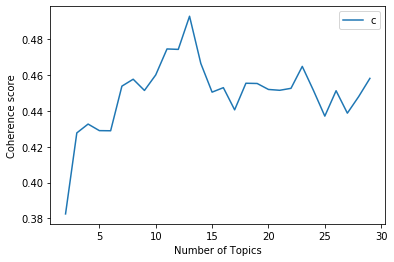

In [206]:
start,stop,step = 2, 30, 1
document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_Ida_coherence_values(term_dictionary,doc_term_matrix,clean_documents_list,start,stop,step,100)
plot_graph(coherence_values,start,stop,step)

In [207]:
list(range(start,stop,step))[coherence_values.index(max(coherence_values))]

13

In [55]:
def remove_word(corpus, words):
    for word in words:
        corpus = [list(filter(lambda a: a != word, item)) for item in corpus]
    return corpus

In [59]:
number_of_topics = 5
words=15
document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
update_documents_list = remove_word(clean_documents_list, ['game', 'player', 'play'])
ldamodel=create_gensim_lda_model(update_documents_list,number_of_topics,words,50)
for idx, topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"get" + 0.010*"like" + 0.009*"one" + 0.007*"great" + 0.007*"time" + 0.007*"still" + 0.007*"everi" + 0.007*"hero" + 0.007*"good" + 0.006*"also" + 0.006*"fix" + 0.006*"even" + 0.006*"new" + 0.006*"pleas" + 0.005*"want"
Topic: 1 Word: 0.015*"fun" + 0.011*"great" + 0.011*"time" + 0.010*"love" + 0.009*"back" + 0.008*"much" + 0.007*"would" + 0.007*"u" + 0.007*"good" + 0.006*"fix" + 0.006*"make" + 0.005*"clan" + 0.005*"like" + 0.005*"pleas" + 0.005*"get"
Topic: 2 Word: 0.022*"good" + 0.019*"like" + 0.015*"love" + 0.013*"make" + 0.011*"best" + 0.008*"need" + 0.008*"mobil" + 0.008*"level" + 0.008*"get" + 0.008*"server" + 0.007*"realli" + 0.007*"ever" + 0.006*"fix" + 0.006*"use" + 0.006*"way"
Topic: 3 Word: 0.024*"get" + 0.013*"pleas" + 0.013*"time" + 0.012*"make" + 0.011*"updat" + 0.009*"like" + 0.009*"fix" + 0.008*"money" + 0.008*"team" + 0.007*"new" + 0.006*"match" + 0.006*"fun" + 0.006*"need" + 0.006*"use" + 0.006*"good"
Topic: 4 Word: 0.013*"make" + 0.010*"match" + 0.00

In [60]:
# classify the reviews by the labels
term_dictionary, doc_term_matrix = prepare_corpus(update_documents_list)
get_document_topics = [sorted(ldamodel.get_document_topics(item), key = lambda x: x[1], reverse = True)[0][0] 
                       for item in doc_term_matrix]
df_reviews['labels'] = get_document_topics

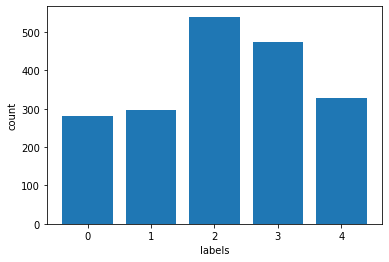

In [61]:
df_labels = df_reviews[['app_id', 'labels']].groupby(by = 'labels').count()
plt.bar(df_labels.index, df_labels['app_id'])
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

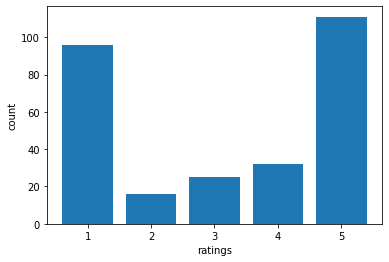

In [82]:
df_labels = df_reviews[['app_id', 'rating','labels']]
df1 = df_labels[df_labels['labels']==0].groupby(by = 'rating').count()
plt.bar(df1.index, df1['app_id'])
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

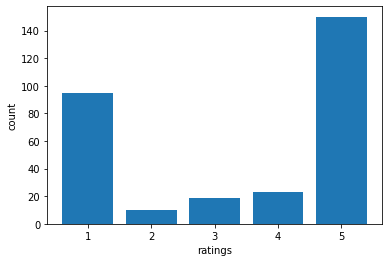

In [83]:
df_labels = df_reviews[['app_id', 'rating','labels']]
df1 = df_labels[df_labels['labels']==1].groupby(by = 'rating').count()
plt.bar(df1.index, df1['app_id'])
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

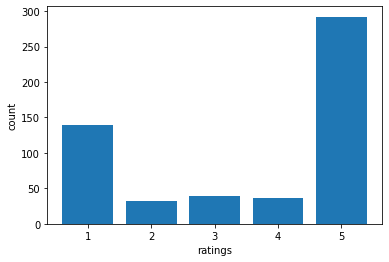

In [84]:
df_labels = df_reviews[['app_id', 'rating','labels']]
df1 = df_labels[df_labels['labels']==2].groupby(by = 'rating').count()
plt.bar(df1.index, df1['app_id'])
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

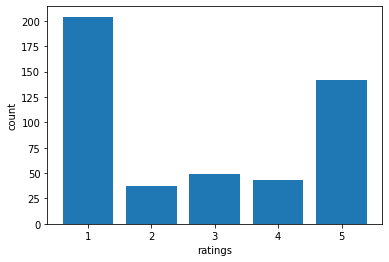

In [85]:
df_labels = df_reviews[['app_id', 'rating','labels']]
df1 = df_labels[df_labels['labels']==3].groupby(by = 'rating').count()
plt.bar(df1.index, df1['app_id'])
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

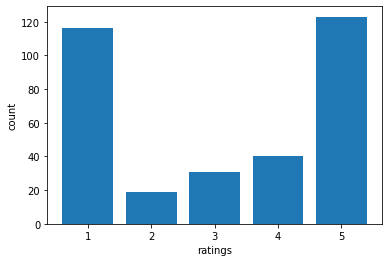

In [86]:
df_labels = df_reviews[['app_id', 'rating','labels']]
df1 = df_labels[df_labels['labels']==4].groupby(by = 'rating').count()
plt.bar(df1.index, df1['app_id'])
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

#### 3.2 Learning Topic Classes
<a id='bert'></a>
#### 3.2.1 Neural Network

[back to top](#header)

In [62]:
from sklearn.model_selection import train_test_split
document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
update_documents_list = remove_word(clean_documents_list, ['game', 'player', 'play'])
joined_list = [" ".join(item) for item in update_documents_list]
x_temp, x_test, y_temp, y_test = train_test_split(joined_list, df_reviews['labels'],
                                                    test_size=0.20, random_state=100)
x_train, x_validation, y_train, y_validation = train_test_split(x_temp, y_temp,
                                                    test_size=0.20, random_state=100)

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_validation = vectorizer.transform(x_validation)
X_test  = vectorizer.transform(x_test)

In [67]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 100)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [71]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_validation)
print(accuracy_score(y_pred, y_validation))

0.4967532467532468


In [72]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 1000, random_state = 100)
model.fit(X_train, y_train)
y_pred = model.predict(X_validation)
print(accuracy_score(y_pred, y_validation))

0.4935064935064935


In [ ]:
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split

document_list = df_reviews['content']
clean_documents_list = preprocess_data(document_list)
update_documents_list = remove_word(clean_documents_list, ['game', 'player', 'play'])
joined_list = [" ".join(item) for item in update_documents_list]
x_temp, x_test, y_temp, y_test = train_test_split(joined_list, df_reviews['labels'],
                                                    test_size=0.20, random_state=100)
x_train, x_validation, y_train, y_validation = train_test_split(x_temp, y_temp,
                                                    test_size=0.20, random_state=100)


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_validation = vectorizer.transform(x_validation)
X_test  = vectorizer.transform(x_test)


input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

In [ ]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [401]:
# enable GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [402]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), batch_size=10)

Train on 1223 samples, validate on 306 samples
Epoch 1/100
1223/1223 [==============================] - ETA: 8s - loss: 1.3000 - accuracy: 0.20 - ETA: 0s - loss: 1.3361 - accuracy: 0.18 - ETA: 0s - loss: 1.2792 - accuracy: 0.20 - ETA: 0s - loss: 1.2990 - accuracy: 0.20 - 0s 239us/step - loss: 1.2862 - accuracy: 0.2101 - val_loss: 1.3954 - val_accuracy: 0.2124
Epoch 2/100
1223/1223 [==============================] - ETA: 0s - loss: 1.4000 - accuracy: 0.20 - ETA: 0s - loss: 1.3111 - accuracy: 0.21 - ETA: 0s - loss: 1.3029 - accuracy: 0.21 - ETA: 0s - loss: 1.2752 - accuracy: 0.21 - 0s 169us/step - loss: 1.2862 - accuracy: 0.2101 - val_loss: 1.3954 - val_accuracy: 0.2124
Epoch 3/100
1223/1223 [==============================] - ETA: 0s - loss: 1.6000 - accuracy: 0.10 - ETA: 0s - loss: 1.2657 - accuracy: 0.22 - ETA: 0s - loss: 1.2515 - accuracy: 0.23 - ETA: 0s - loss: 1.2706 - accuracy: 0.21 - 0s 175us/step - loss: 1.2862 - accuracy: 0.2101 - val_loss: 1.3954 - val_accuracy: 0.2124
Epoch 4/

In [403]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.2101
Validation Accuracy:  0.2124
